# Gradient descent on Soft-DTW metric metric using PyTorch

This notebook is inspired by the notebook of Romain Tavenard about the Soft-DTW metric: 
https://github.com/rtavenar/notebooks-ml4ts/blob/main/02_softdtw_sol.ipynb

The aim here is to use the PyTorch backend to compute the gradient of the metric.

In [20]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import torch
from celluloid import Camera
from IPython.display import HTML
from tslearn.backend import instanciate_backend
from tslearn.metrics import soft_dtw, SoftDTW, soft_dtw_alignment, SquaredEuclidean

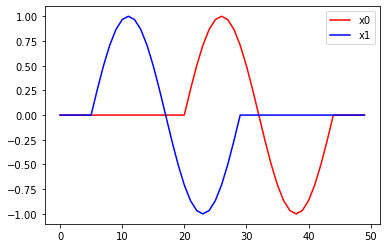

In [21]:
size = 50
x0 = np.zeros((size, ))
x0[20:20+size//2] = np.sin(np.linspace(0, 2 * np.pi, size // 2))

x1 = np.zeros((size, ))
x1[5:5+size//2] = np.sin(np.linspace(0, 2 * np.pi, size // 2))

plt.figure()
plt.plot(x0, 'r-', label='x0')  # red
plt.plot(x1, 'b-', label='x1')  # blue
plt.legend()
plt.show()


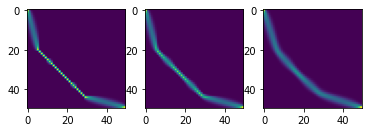

In [22]:
for i, gamma in enumerate([1e-3, 1e-1, 1.]):
    plt.subplot(1, 3, i + 1)
    A_gamma, dst = soft_dtw_alignment(x0, x1, gamma=gamma)
    plt.imshow(A_gamma)

In [23]:
def soft_dtw_grad(x, y, gamma):    
    D = SquaredEuclidean(x.reshape((-1, 1)), y.reshape((-1, 1)))
    sdtw = SoftDTW(D, gamma=gamma)
    sdtw.compute()
    A_gamma = sdtw.grad()
    grad = D.jacobian_product(A_gamma)
    return grad

In [24]:
def animate_gradient_descent(list_of_successive_time_series, show_x1=False):
    fig = plt.figure()
    camera = Camera(fig)
    for x in list_of_successive_time_series:
        plt.plot(x.ravel(), 'k-')
        plt.plot(x0, 'r-', label='x0')
        if show_x1:
            plt.plot(x1, 'b-', label='x1')
        camera.snap()    
    anim = camera.animate()
    plt.close()
    return HTML(anim.to_jshtml())

In [25]:
eta = 1e-1
n_epochs = 100
gamma = .1

list_x = [.1 * np.random.randn(size, 1) + x0.reshape((-1, 1))]

for i_epoch in range(n_epochs):
    x_t = list_x[-1]
    x_tp1 = x_t - eta * soft_dtw_grad(x_t, x0, gamma)
    list_x.append(x_tp1)

animate_gradient_descent(list_x)

In [26]:
def soft_dtw_grad_pytorch(x, y, gamma):    
    D = SquaredEuclidean(x.reshape((-1, 1)), y.reshape((-1, 1)), be='pytorch')
    sdtw = SoftDTW(D, gamma=gamma, be='pytorch')
    sdtw.compute()
    A_gamma = sdtw.grad()
    grad = D.jacobian_product(A_gamma)
    return grad

In [27]:
eta = 1e-1
n_epochs = 100
gamma = .1

be = instanciate_backend('pytorch')
x0 = be.array(x0)

list_x = [.1 * be.random.randn(size, 1) + be.reshape(x0, (-1, 1))]

for i_epoch in range(epochs):
    x_t = list_x[-1]
    x_tp1 = x_t - eta * soft_dtw_grad_pytorch(x_t, x0, gamma)
    list_x.append(x_tp1)

animate_gradient_descent(list_x)